Install dependencies

In [ ]:
!pip install numpy sklearn pandas matplotlib

Import libraries

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from datetime import datetime
from sklearn.decomposition import PCA
from sklearn.svm import SVR

In [ ]:
TRAIN_CSV = "https://raw.githubusercontent.com/ptleskin/MultivariateSeasonalTimeseriesPredictionPCA/master/data/training_set.csv"
TEST_CSV = "https://raw.githubusercontent.com/ptleskin/MultivariateSeasonalTimeseriesPredictionPCA/master/data/test_set.csv"

Read training data:

In [ ]:
n_keys = 11 # number of keywords
sources = ['x_{}'.format(i) for i in range(n_keys)]

df = pd.read_csv(TRAIN_CSV, sep=';', header=None, names=['ds'] + sources + ['y'])

# save the timestamps in ordinal format for later use:
t_train = [datetime.strptime(st, '%Y-%m-%d %H:%M:%S').toordinal() for st in df['ds']]

df.tail()

,ds,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,y
277,2014-04-28 00:00:00,8.0,2.0,0.0,1.0,3.0,1.0,1.0,4.0,14.0,3.0,15.0,5
278,2014-05-05 00:00:00,6.0,0.0,3.0,3.0,17.0,0.0,1.0,4.0,23.0,1.0,6.0,12
279,2014-05-12 00:00:00,6.0,0.0,5.0,2.0,12.0,0.0,0.0,8.0,32.0,1.0,4.0,11
280,2014-05-19 00:00:00,4.0,2.0,1.0,3.0,13.0,0.0,0.0,13.0,17.0,2.0,6.0,10
281,2014-05-26 00:00:00,13.0,2.0,0.0,1.0,5.0,1.0,0.0,5.0,22.0,14.0,2.0,1


Read test data:

In [ ]:
df2 = pd.read_csv(TEST_CSV, sep=';', header=None, names = ['ds'] + sources)

# save the timestamps in ordinal format for later use:
t_test = [datetime.strptime(st, '%Y-%m-%d %H:%M:%S').toordinal() for st in df2['ds']]

df2.head()

,ds,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10
0,2014-06-02 00:00:00,9.0,2.0,2.0,0.0,11.0,1.0,0.0,10.0,15.0,6.0,1.0
1,2014-06-09 00:00:00,10.0,1.0,3.0,4.0,16.0,0.0,0.0,7.0,46.0,2.0,4.0
2,2014-06-16 00:00:00,6.0,2.0,0.0,1.0,10.0,0.0,0.0,8.0,20.0,1.0,4.0
3,2014-06-23 00:00:00,28.0,1.0,4.0,2.0,8.0,0.0,0.0,5.0,17.0,9.0,3.0
4,2014-06-30 00:00:00,8.0,4.0,0.0,1.0,13.0,0.0,0.0,3.0,12.0,5.0,7.0


Notice that time stamps of the training data continue in the test data.

Study the data by plotting it:

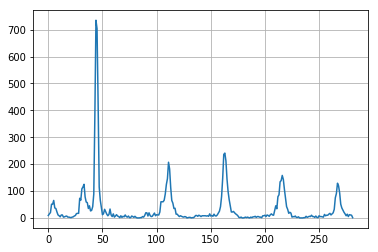

In [ ]:
fig, ax = plt.subplots()
ax.plot(df['y'].values)
ax.grid()
plt.show()

So we are dealing with a relatively small data set with periodical behaviour.

Now plot the keyword counts:

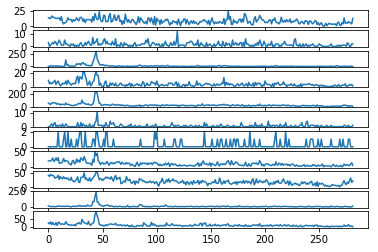

In [ ]:
fig, ax = plt.subplots(len(sources), 1, sharex='col', sharey='row')

for i,s in enumerate(sources):
    ax[i].plot(df[s].values)

plt.show()

Let's take a look at the correlation coefficients, to see how much mutual information there is in the keyword data:

In [ ]:
pd.DataFrame(data = np.corrcoef(df[sources].values, rowvar = False))

,0,1,2,3,4,5,6,7,8,9,10
0,1.000000,0.165659,0.240735,0.261566,0.323946,0.148247,0.109507,0.406442,0.430403,0.247847,0.318768
1,0.165659,1.000000,0.188686,0.126909,0.234532,0.170091,0.104815,0.212833,0.240584,0.207836,0.227255
2,0.240735,0.188686,1.000000,0.638754,0.870728,0.381759,0.282963,0.603716,0.469311,0.893345,0.795883
3,0.261566,0.126909,0.638754,1.000000,0.665850,0.362167,0.251680,0.631225,0.525285,0.503034,0.656606
4,0.323946,0.234532,0.870728,0.665850,1.000000,0.479626,0.242197,0.730889,0.603969,0.813183,0.868653
5,0.148247,0.170091,0.381759,0.362167,0.479626,1.000000,0.257780,0.330405,0.284482,0.328191,0.402064
6,0.109507,0.104815,0.282963,0.251680,0.242197,0.257780,1.000000,0.279513,0.130701,0.244170,0.214234
7,0.406442,0.212833,0.603716,0.631225,0.730889,0.330405,0.279513,1.000000,0.677847,0.508777,0.716370
8,0.430403,0.240584,0.469311,0.525285,0.603969,0.284482,0.130701,0.677847,1.000000,0.429498,0.612721
9,0.247847,0.207836,0.893345,0.503034,0.813183,0.328191,0.244170,0.508777,0.429498,1.000000,0.731535


There are many off-diagonal values in range 0.5 to 1.0, so the columns in the data are strongly correlated.

Next we will apply dimensionality reduction with PCA:

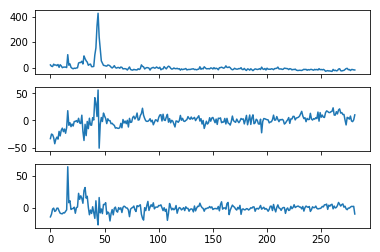

(array([0.86, 0.07, 0.03]), 0.947278311828126)

In [ ]:
n_components = 3
pca = PCA(n_components=n_components)
pca.fit(df[sources].values)

X3 = pca.transform(df[sources].values)
X3_test = pca.transform(df2[sources].values)

fig, axs = plt.subplots(n_components, 1, sharex='col', sharey='row')

pca_sources = ['p_{}'.format(i) for i in range(n_components)]

if n_components==1:
    axs.plot(X3[:,0])
    df[pca_sources[0]] = X3[:,0]
    df2[pca_sources[0]] = X3_test[:,0]
else:
    for i,ax in enumerate(axs):
        ax.plot(X3[:,i])
        df[pca_sources[i]] = X3[:,i]
        df2[pca_sources[i]] = X3_test[:,i]

plt.show()

np.set_printoptions(precision=2)
(pca.explained_variance_ratio_, np.sum(pca.explained_variance_ratio_))

The first PCA component explain 86 per cent of the data, and would produce a feasible result when used in combination with the disease count data. However we will choose the three first components with 95 per cent value.

Due to the small data size we chose to use a Support Vector Machine, and predict the next y-value by a longer sequence of earlier samples.

In addition to the x[0], x[1], ... x[10] values, we will also use y[n-1], y[n-2], ... the predict next y[n].

Initialize a Support Vector Machine for regression:

In [ ]:
clf = SVR(kernel='linear')

In [ ]:
n_timesteps = 125 # number of time steps

X, y = [], [] 

data = df[pca_sources+['y']].values

for i in range(df.shape[0]-n_timesteps+1):
    D = data[i:i+n_timesteps,:].flatten() # collect n_timesteps number of rows, and convert into 1D array
    X.append(D[:-1]) # collect keyword counts into X, leave out the last number = y-value
    y.append(D[-1])  # and disease counts into y

Fit the SVR:

In [ ]:
clf.fit(X, y)

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

Use the last y-value from the training data as a prior for future y-values:

In [ ]:
df2['y'] = y[-1]

Convert the data matrix into a format suitable for the regressor:

In [ ]:
dataX = np.concatenate((data[1-n_timesteps:], df2[pca_sources + ['y']].values), axis=0)

X2 = []
for i in range(len(dataX)-n_timesteps+1):
    D = dataX[i:i+n_timesteps,:].flatten()
    X2.append(D[:-1])

Predict the first estimate converted into non-negative integers:

In [ ]:
pred_0 = clf.predict(X2).astype('int')
pred_0[pred_0<0] = 0
pred_0

array([ 0,  6,  3,  1,  0,  0,  5,  3,  4,  3,  6, 11, 16,  8,  7,  9,  3,
        2,  1,  2,  1,  7,  7,  3,  5,  9,  6, 11, 13, 11,  7,  7, 10, 21,
       27, 49, 65, 77, 72, 65, 56, 32, 25,  6,  5,  1, 10, 11,  8,  5,  4,
       11])

Update the y-prior with the first prediction:

In [ ]:
df2['y'] = pred_0

Make the second prediction:

In [ ]:
dataX = np.concatenate((data[1-n_timesteps:], df2[pca_sources + ['y']].values), axis=0)

X2 = []
for i in range(len(dataX)-n_timesteps+1):
    D = dataX[i:i+n_timesteps,:].flatten()
    X2.append(D[:-1])

predictions = clf.predict(X2).astype('int')

predictions[predictions<0] = 0

Plot the data for visual evaluation:

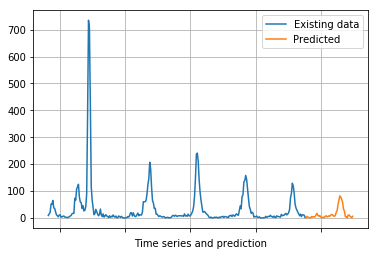

In [ ]:
fig, ax = plt.subplots()

ax.plot(t_train, df['y'].values)
ax.plot(t_test, predictions)

ax.set_xticklabels([])
ax.grid()
ax.legend(['Existing data', 'Predicted'])
plt.xlabel('Time series and prediction')
plt.show()

To have a closer look we will plot the last 50 values of the training data and the predicted sequence:

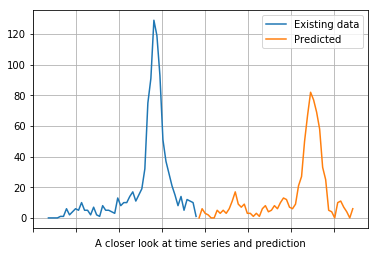

In [ ]:
fig, ax = plt.subplots()

ax.plot(t_train[-50:], df['y'].values[-50:])
ax.plot(t_test, predictions)

ax.set_xticklabels([])
ax.grid()
ax.legend(['Existing data', 'Predicted'])
plt.xlabel('A closer look at time series and prediction')
plt.show()

predictions

In [ ]:
predictions

array([ 0,  6,  3,  2,  0,  0,  5,  3,  5,  3,  6, 11, 17,  9,  7,  9,  3,
        3,  1,  3,  1,  6,  8,  4,  5,  8,  6, 10, 13, 12,  7,  6,  9, 21,
       27, 50, 67, 82, 77, 69, 58, 33, 25,  5,  4,  0, 10, 11,  7,  4,  0,
        6])